## Aspect-Based Sentiment Analysis: Findings from Natural Language
#### Code File \#1: Data Exploration & Engineering

Tahmeed Tureen - University of Michigan, Ann Arbor<br>
Python file: <b>data-engin-tureen.py</b> <br>
Description: Code to process the XML format dataset from 2014 SemEval Task 4

In [203]:
# Import Libraries
import xml.etree.ElementTree as ET # To Parse the XML data
import pandas as pd # import Pandas library
import pickle # for pickling Python data structures
from collections import Counter

### Part I: Process the Raw Data

In [204]:
# Read in XML data (courtesy of SemEval 2014 committee)
tree = ET.parse('../SemEval_14_Train/Restaurants_Train_v2.xml')
# tree = ET.parse('../SemEval_14_Train/play.xml')
root = tree.getroot()

The data is nested like a tree because it's in XML format <br>
We will loop through all of the sentences (reviews) <br>
The whole XML data is nested under the root term: sentences <br>
This root has branches named "sentence" (individual review) and we have multiple of these

In [205]:
processed_reviews = [] # this list will contain dictionaries, eventually we will convert it to a Pandas DataFrame

for sen in root.findall("sentence"):
    # this dictionary will store the columns we are interested in storing for our processed dataset
    data_dict = {} 

    review = sen[0].text # assign the text review to this variable
    
    # We add this at the beginning of the for loop to avoid adding terms to reviews that don't have terms
    term_tokens = [] # slot 1 for value_container 
    term_pols = [] # slot 2 for value_container
    cat_tokens = [] # list of all of the labeled categories for the data
    cat_pols = [] # list of the associated polarities
    
    if sen.find("aspectTerms"): # if there exists aspect terms in review 

        # we make define these lists because a review can have multiple aspects
        term_tokens = [] # slot 1 for value_container
        term_pols = [] # slot 2 for value_container
        
        # Iterate through individual aspect terms and strip its polarity
        for branch in sen.find("aspectTerms").findall("aspectTerm"):
            term = branch.get("term")
            term_polarity = branch.get("polarity")

            term_tokens.append(term)
            term_pols.append(term_polarity)

    if sen.find("aspectCategories"): # if there exists labeled categories 

        # We define these lists because a review can have multiple aspects
        cat_tokens = [] # list of all of the labeled categories for the data
        cat_pols = [] # list of the associated polarities

        for branch in sen.find("aspectCategories").findall("aspectCategory"):
            category = branch.get("category")
            cat_polarity = branch.get("polarity")

            cat_tokens.append(category)
            cat_pols.append(cat_polarity)

    # Start assigning the values we just mined to appropriate keys in data_dict
    data_dict["Review_ID"] = sen.attrib["id"]
    data_dict["Review"] = review
    data_dict["Aspect_Term"] = term_tokens
    data_dict["Aspect_Polarity"] = term_pols
    data_dict["Aspect_Count"] = len(term_tokens)
    data_dict["Category"] = cat_tokens
    data_dict["Category_Polarity"] = cat_pols
    data_dict["Category_Count"] = len(cat_tokens)

    # each element in the following list will be a row for our processed dataset
    processed_reviews.append(data_dict) # append data_dict

We will convert this list into a Pandas DataFrame for convenience and also save it as a pickled file

In [206]:
reviews_pd = pd.DataFrame(processed_reviews)
print("Shape of Training data", reviews_pd.shape)
# reviews_pd.head(3)

Shape of Training data (3041, 8)


In [240]:
col_reform = ['Review_ID', 'Review', 'Aspect_Term', 'Aspect_Polarity', 'Aspect_Count', 'Category', 'Category_Polarity', 'Category_Count']
reviews_pd = reviews_pd[col_reform]
reviews_pd.head(2)

,Review_ID,Review,Aspect_Term,Aspect_Polarity,Aspect_Count,Category,Category_Polarity,Category_Count
0,3121,But the staff was so horrible to us.,[staff],[negative],1,[service],[negative],1
1,2777,"To be completely fair, the only redeeming fact...",[food],[positive],1,"[food, anecdotes/miscellaneous]","[positive, negative]",2


Need to validate if we are actually data wrangling appropriate by checking how many aspect terms we are counting and if it is consistent with what SemEval provides in their paper (n = 3693)

In [208]:
print(sum(reviews_pd.iloc[:,4])) # the Aspect Count column
print(sum([len(x) for x in reviews_pd.iloc[:,2]])) # the Aspect Term column

3693
3693


Now, let's look at if we have the correct number of categories (n = 3713)

In [209]:
print(sum(reviews_pd.iloc[:,7]))
print(sum([len(x) for x in reviews_pd.iloc[:,5]]))

3713
3713


Both look good!! So, our data engineering is good so far

### Part II: Dataset Exploration

Now, we need to think about how we are going engineer this dataset... the test data SemEval provides doesn't have the ground truth sentiment values. So, we will have to do a train-test split so engineering this dataset needs some thinking!

First, we noticed that some reviews have multiple aspect terms but have less aspect categories present in the dataset... we need to investigate this a bit more

In [210]:
# Let's see if there is an imbalance in the number of aspect terms we have and the aspect category
print(len(reviews_pd.iloc[0,2]) == len(reviews_pd.iloc[0,5]))
print(len(reviews_pd.iloc[1,2]) == len(reviews_pd.iloc[1,5]))

True
False


In [211]:
# make subsets of the data that have either more aspect terms or more categories then terms...
reviews_pd_MoreTerms = reviews_pd[reviews_pd.Aspect_Count > reviews_pd.Category_Count]
print(reviews_pd_MoreTerms.shape)

reviews_pd_MoreCats = reviews_pd[reviews_pd.Aspect_Count < reviews_pd.Category_Count]
print(reviews_pd_MoreCats.shape)

print(reviews_pd_MoreTerms.shape[0] + reviews_pd_MoreCats.shape[0])

# make subset of the data that has perfect balance
reviews_pd_Balance = reviews_pd[reviews_pd.Aspect_Count == reviews_pd.Category_Count]
print(reviews_pd_Balance.shape[0])

(721, 8)
(1177, 8)
1898
1143


Only 1143 of the reviews have a the same number of aspect terms as the categories. We need to dig a little deeper about how the categories are assigned for the imbalanced reviews. The SemEval paper doesn't discuss this feature of the data annotation process too much, but they mention that there were disagreements between annotators.<br>

Findings:
- 721 reviews have more aspect terms than aspect categories<br>
- 1177 reviews have less aspect terms than aspect categories<br>
- 1143 reviews have the same # of aspect terms as aspect categories

In [212]:
print(reviews_pd[reviews_pd.Category_Count == 0].shape[0])

reviews_pd_NoAspTerms = reviews_pd[reviews_pd.Aspect_Count == 0]
print(reviews_pd_NoAspTerms.shape[0])

0
1020


There are actually 1020 rows without any aspect terms at all. So, we can't even do term extraction for some of these reviews... But, all of the reviews have atleast one category associated with it... this is very interesting<br>

We'll look at the subset of reviews that have more aspect terms than categories. My hunch is that some of the reviews that have multiple aspect terms and lower categories are grouped into the same category. That is, maybe all of the aspect terms fall into just one category, and the annotators didn't bother adding the same category twice.<br>

#### More Aspect Terms than Category Terms

In [213]:
# Save these subset data frames into CSVs so we can manually go through and explore them
reviews_pd_MoreTerms = reviews_pd_MoreTerms[col_reform] # reformat the column arrangement
reviews_pd_MoreTerms.to_csv("exploration_data/reviews_more_AspTerms.csv")

print(Counter(reviews_pd_MoreTerms.Aspect_Count))
print(Counter(reviews_pd_MoreTerms.Category_Count))

Counter({2: 342, 3: 225, 4: 101, 5: 29, 6: 15, 7: 5, 8: 3, 9: 1})
Counter({1: 592, 2: 109, 3: 19, 4: 1})


Our hunch was correct, it looks like most of these reviews have multiple aspect terms and they all fall into one of the categories... The annotators didn't include the same category more than once... We need to engineer this for our dataset<br>

Findings:
- When Category Count = 1, then all of the aspect terms in the review belong to that category
- When Category Count > 1, then the aspect terms are divided (this is more nuanced)

We can only really account for the first bullet point and just collapse all of the aspect terms to that category and create repeating rows. But, apart from that... there isn't much we can do to re-annotate this dataset

#### More Categories than Aspect Term

In [223]:
reviews_pd_MoreCats = reviews_pd_MoreCats[col_reform]
reviews_pd_MoreCats.to_csv("exploration_data/reviews_more_CatTerms.csv")

print(Counter(reviews_pd_MoreCats.Aspect_Count))
print(Counter(reviews_pd_MoreCats.Category_Count))

Counter({0: 1020, 1: 138, 2: 18, 3: 1})
Counter({1: 988, 2: 165, 3: 22, 4: 2})


Findings:
- When Aspect Terms = 0, then Category = "Anecdotes/Miscellanous"
- When Aspect Terms > 0, then Categories >= 1

We also note that some of the reviews that don't have aspect terms still fall into a relevant category... the annotators did not annotate them well!

We're gonna save this Pandas dataframe as a pickled file for future use

In [224]:
# Save data as pickled file so we can read it in easily later
reviews_pd.to_pickle("pickled_data/pickled_reviews_pd.pkl")
# test_pickle = pickle.load(open("pickled_reviews_pd.pkl", "rb"))

### Part III: Data Engineering

In this next section, we process the dataframe to create a new one that is re-formatted to an Category level instead of review level. In the previous dataframe the rows represented an entire review whereas now a row will represent a respective Category in the review. This will prevent a row from having multiple category, this will be good for our training

In [252]:
data_list_CatLevel = []

# loop through the current 
for row in reviews_pd.itertuples(index=False):
    category_list = row.Category
    polarity_list = row.Category_Polarity
    
#     print(len(polarity_list) == len(category_list))
    for i in range(len(category_list)):
        data_dict = {}
        
        data_dict["Review_ID"] = row.Review_ID
        data_dict["Review"] = row.Review
        
        current_pol = polarity_list[i] # get the polarity of the current category
        current_category = category_list[i]
        
        if current_pol == "conflict":
            current_pol = "neutral" # collapse these two levels together as one 
        
        if current_category == "anecdotes/miscellaneous": # rename this label for visualization convenience
            current_category = "other"
        
        
        data_dict["Aspect_Term"] = row.Aspect_Term
        data_dict["Aspect_Count"] = row.Aspect_Count
        data_dict["Aspect_Polarity"] = row.Aspect_Polarity
        data_dict["Category"] = current_category
        data_dict["Category_Polarity"] = current_pol

        data_list_CatLevel.append(data_dict)

#         if pol == "conflict":
#             pol = "neutral"

#         data_dict["Aspect Term"] = terms_list[i]
#         data_dict["Aspect Polarity"] = pol
#         data_dict["All Aspect Terms"] = terms_list

#         aspects_data_list.append(data_dict)

In [253]:
# Convert to Pandas Data Frame for convenience
reviews_pd_CatLevel = pd.DataFrame(data_list_CatLevel)
reviews_pd_CatLevel = reviews_pd_CatLevel[col_reform[0:7]]
reviews_pd_CatLevel.head(5)

,Review_ID,Review,Aspect_Term,Aspect_Polarity,Aspect_Count,Category,Category_Polarity
0,3121,But the staff was so horrible to us.,[staff],[negative],1,service,negative
1,2777,"To be completely fair, the only redeeming fact...",[food],[positive],1,food,positive
2,2777,"To be completely fair, the only redeeming fact...",[food],[positive],1,other,negative
3,1634,"The food is uniformly exceptional, with a very...","[food, kitchen, menu]","[positive, positive, neutral]",3,food,positive
4,2534,Where Gabriela personaly greets you and recomm...,[],[],0,service,positive


In [246]:
reviews_pd_CatLevel.shape

(3713, 7)

Notice that the number of rows have changed. This means we have repeating reviews in this dataset but each individual row is in now respective of a category!

### Part IV: Train/Test Split

We will now split our dataset into a train and test subsets (85% to 15%)

In [279]:
import math
train_split = math.floor(3713 * 0.85)
test_split = 3713 - math.floor(3713 * 0.85)
print([train_split, test_split])

[3156, 557]


In [284]:
train_data = reviews_pd_CatLevel.iloc[0:train_split,]
train_data.shape
train_data.tail()

,Review_ID,Review,Aspect_Term,Aspect_Polarity,Aspect_Count,Category,Category_Polarity
3151,1163,The service is fantastic.,[service],[positive],1,service,positive
3152,216,I recommend that you try this hidden spot whic...,[],[],0,other,positive
3153,1109,The garlic mashed potatoes are hands down the ...,[garlic mashed potatoes],[positive],1,food,positive
3154,899,Food and service was okay.,"[Food, service]","[neutral, neutral]",2,food,neutral
3155,899,Food and service was okay.,"[Food, service]","[neutral, neutral]",2,service,neutral


In [285]:
test_data = reviews_pd_CatLevel.iloc[(3713 - test_split):,]
test_data.shape
test_data.tail()

,Review_ID,Review,Aspect_Term,Aspect_Polarity,Aspect_Count,Category,Category_Polarity
3708,1063,But that is highly forgivable.,[],[],0,other,positive
3709,777,"From the appetizers we ate, the dim sum and ot...","[appetizers, dim sum, foods, food]","[positive, positive, positive, positive]",4,food,positive
3710,875,"When we arrived at 6:00 PM, the restaurant was...",[],[],0,other,neutral
3711,671,Each table has a pot of boiling water sunken i...,"[table, pot of boiling water, meats, vegetable...","[neutral, neutral, neutral, neutral, neutral, ...",6,food,neutral
3712,617,I am going to the mid town location next.,[],[],0,other,neutral


In [247]:
## Save this as a pickled file for future use
reviews_pd_CatLevel.to_pickle("pickled_data/pickled_reviews_pd_CatLevel.pkl")

### Data Summaries/ Manipulation for Visualization

In this next section, we do some exploratory data summaries and also create some files so we can do some visualizations using R's ggplot2 package

In [295]:
# Let's look at the distribution of the Aspect Categories first in the whole data
data_for_viz = [] # for visualization later

category_freq = []
for cat in reviews_pd['Category']:
    category_freq += cat
category_freq = Counter(category_freq)

data_for_viz.append(category_freq)
category_freq

Counter({'ambience': 431,
         'anecdotes/miscellaneous': 1132,
         'food': 1232,
         'price': 321,
         'service': 597})

It looks like we have 5 aspect categories (as claimed by SemEval) and the distribution looks exactly the same as well!

In [297]:
# Let's look at the distribution of the Aspect Categories first in the train data
category_freq = []
for cat in train_data['Category']:
    category_freq.append(cat)
    
category_freq = Counter(category_freq)
data_for_viz.append(category_freq)
category_freq

Counter({'ambience': 367,
         'food': 1050,
         'other': 955,
         'price': 277,
         'service': 507})

In [298]:
# Let's look at the distribution of the Aspect Categories first in the test data
category_freq = []
for cat in test_data['Category']:
    category_freq.append(cat)
    
category_freq = Counter(category_freq)
data_for_viz.append(category_freq)
category_freq

Counter({'ambience': 64,
         'food': 182,
         'other': 177,
         'price': 44,
         'service': 90})

In [301]:
# Write to a CSV so we can import into R for visualizations
temp = pd.DataFrame(data_for_viz)
temp.to_csv("exploration_data/category_freq.csv")

In [303]:
Counter(train_data.Category_Polarity)
Counter(test_data.Category_Polarity)

Counter({'negative': 124, 'neutral': 131, 'positive': 302})

We see a clear imbalance in our labels... there are a ton of positive sentiments than there are negative and neutral sentiments

In [254]:
import matplotlib.pyplot as plt
import numpy as np

In [255]:
index = np.arange(len(category_freq.keys()))
nums = category_freq.values()
labels = category_freq.keys()

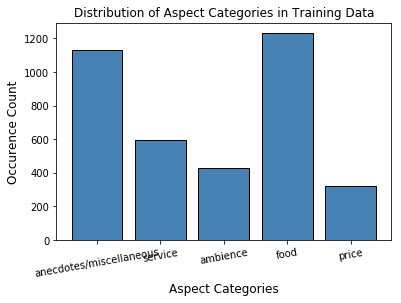

In [257]:
plt.bar(index, nums)
plt.bar(labels, nums, color='steelblue',  edgecolor='black')

# add additional features to plot
plt.title("Distribution of Aspect Categories in Training Data")
plt.ylabel("Occurence Count", fontsize = 12)
plt.xlabel("Aspect Categories", fontsize = 12)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.show()

Now we make a bar plot for the aspect terms

In [117]:
index = np.arange(len(term_freq_top15_x)) # for the xticks
index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

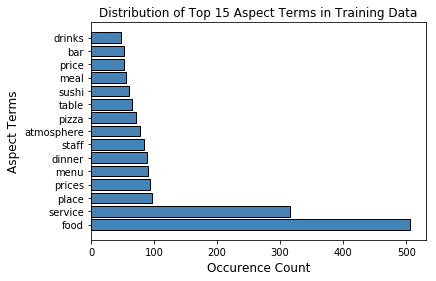

In [119]:
plt.barh(index, term_freq_top15_y,
         color='steelblue',  edgecolor='black')
plt.yticks(index, term_freq_top15_x, fontsize = 10)
plt.title("Distribution of Top 15 Aspect Terms in Training Data")
plt.ylabel("Aspect Terms", fontsize = 12)
plt.xlabel("Occurence Count", fontsize = 12)
plt.show()
plt.savefig('term-dist.png')

#### Let's look at the Polarity Distribution next
We can just look at the counts of the positive, negative, and neutral sentiments in the category polarity column of our reviews_pd dataframe

In [113]:
# Let's look at the distribution of the Aspect Categories first
category_freq = []
for cat in reviews_pd['Category Polarity']:
    category_freq += cat
category_freq = Counter(category_freq)
category_freq

# 500 + 195

Counter({'conflict': 195, 'negative': 839, 'neutral': 500, 'positive': 2179})